<a href="https://colab.research.google.com/github/MLHat/Collecting_Data/blob/main/A5_Martijn_Hatfield.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Extracted Features to topic model with HTRC FeatureReader and Gensim
This notebook will introduce [HTRC Extracted Features](https://wiki.htrc.illinois.edu/x/kYC2B) files, the [HTRC FeatureReader](https://github.com/htrc/htrc-feature-reader) Python library, and demo how EF files can be used to topic model a workset (collection) of volumes using [Gensim](https://radimrehurek.com/gensim/). This can be helpful both as exploratory data analysis, since anyone can download EF files whenever they'd like, as well as more robust analysis, as Gensim is a powerful topic modeling/machine learning library. This notebook will introduce a few new functions to reformat EF files to a format that can be fed directly into a topic modeling library, such as Gensim or MALLET, as well as some very entry-level visualization of our generated topics using [pyLDAvis](https://github.com/bmabey/pyLDAvis).

Google Colaboratory (Colab) comes with a number of Python libraries built-in, but there are a few it doesn't have. These we will install directly on our Google server that runs this notebook, using `pip` a command line Python package manager. 

**NOTE: There will be a warning after running this cell that produces a "restart runtime" button. Do not worry about the warning, however, you will need to click on the button for the rest of the code in the notebook to work.**

In [1]:
!pip install htrc-feature-reader
!pip install pyLDAvis

First, as almost always with a Jupyter notebook, we'll import the libraries that we'll be using. We need to do this in order to tell Python which libraries have the commands/methods we'll be using:

In [2]:
import pandas as pd
from htrc_features import FeatureReader, Volume
from tqdm.notebook import trange, tqdm
import os
import shutil
import nltk
import gensim

# Because some of our libraries will throw many, many warnings for future changes to their code:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

We've imported:
- [Pandas](https://pandas.pydata.org/) a common library for working with large data, especially text data, while doing data science-y things.
- the HTRC FeatureReader, a specialty Python library for working with EF files.
- [TQDM](https://pypi.org/project/tqdm/) a library that allows for quick and easy progress bars for longer computational tasks.
- `NLTK`, the [Natural Language Toolkit](https://www.nltk.org/)
- Two built-in Python libraries, `shutil` and `os` which help us deal with files and file systems

You can think of importing libraries as basically getting our tools into our workspace, because we know that for some tasks we'll need a screwdriver and for others we may need some duct tape or a drill.


## Working with Volumes

We'll first use the FeatureReader to quickly take a look at EF data. The HTRC FeatureReader is a Python library that was written to make working with the EF files, especially for exploratory analysis, easier. The FeatureReader library aggregates information at a collection and volume level, and also has functions/methods at both levels. For this notebook, we'll be using the EF data at the volume level, though iterating through multiple volumes.

When using the FeatureReader, the first step is usually to create a `Volume` object out of one EF file. We're going to do this by giving the method `Volume()` a HathiTrust ID (HTID), but, if we had a lot of volumes we wanted to look at EF data for, we could also give it a file path to an EF file we already downloaded to our own computer:

In [4]:
test_vol = Volume('mdp.39015066088678')
print(f"{test_vol.title}, by {test_vol.author}, {test_vol.pub_date}, {test_vol.id}")

The outsiders /, by ['Hinton, S. E.'], 1967, mdp.39015066088678


Above we see that we created a FeatureReader `Volume` and we use a few built-in methods for a `Volume` to return metadata about the book--author, title, pub date, and HTID. This metadata is bibliographic, and was assigned by a librarian or cataloger at the institution that submitted the item to HathiTrust. This is handy because it can be used as ground truth for machine learning tasks as well as used during the text analysis pipe line, such as for de-duplicating volumes. There are more metadata fields available than above, and you can see all the options by typing `test_vol.` below then hitting `Tab`, which will trigger a pop-up menu listing the possible methods available. See some samples and explore other fields below:

In [5]:
# returns HT record number (which can help with de-duplicating)
print(test_vol.oclc)

# returns publisher information for the volume
print(test_vol.publisher)
 
# returns a code for the institution that submitted the item to HathiTrust
print(test_vol.source_institution)

# EXPLORE OTHER AVAILABLE METHODS/FIELDS
print(test_vol.date_created)
print(test_vol.genre)

299855
Viking Press
MIU
20200209
['document (computer)', 'fiction']


Some of the methods that pop-up in the above cell are more complex than just returning metadata fields in the file. Some of the methods will instead return new Pandas DataFrames (basically big, interactive tables of data that we'll be using a lot today) with information. For example, we can use `test_vol.begin_line_chars()` to return a DataFrame of the characters that start each line on a given page. Explore some of the other options in the cell below by commenting or un-commenting the code lines (by adding/removing a `#` in front of the line):

In [10]:
# returns a DataFrame (DF) with begin-line characters for each page
#test_vol.begin_line_chars()

# returns a DF with line counts for each page
#test_vol.line_counts()

# returns a DF with empty line counts for each page
test_vol.empty_line_counts()

# EXPLORE OTHER METHODS!




page
7      0
9      2
10     0
11     0
15     0
      ..
193    0
194    0
197    0
200    0
201    3
Name: emptyLineCount, Length: 187, dtype: int64

Beyond just generating these DataFrames, we can also plot many of them very quickly, which helps us better visualize a large amount of data. For instance, if we wondered about the textual structure of our volume, we may use `.tokens_per_page()` to visualize how many words are on each page of our volume, and see if there is anything interesting:

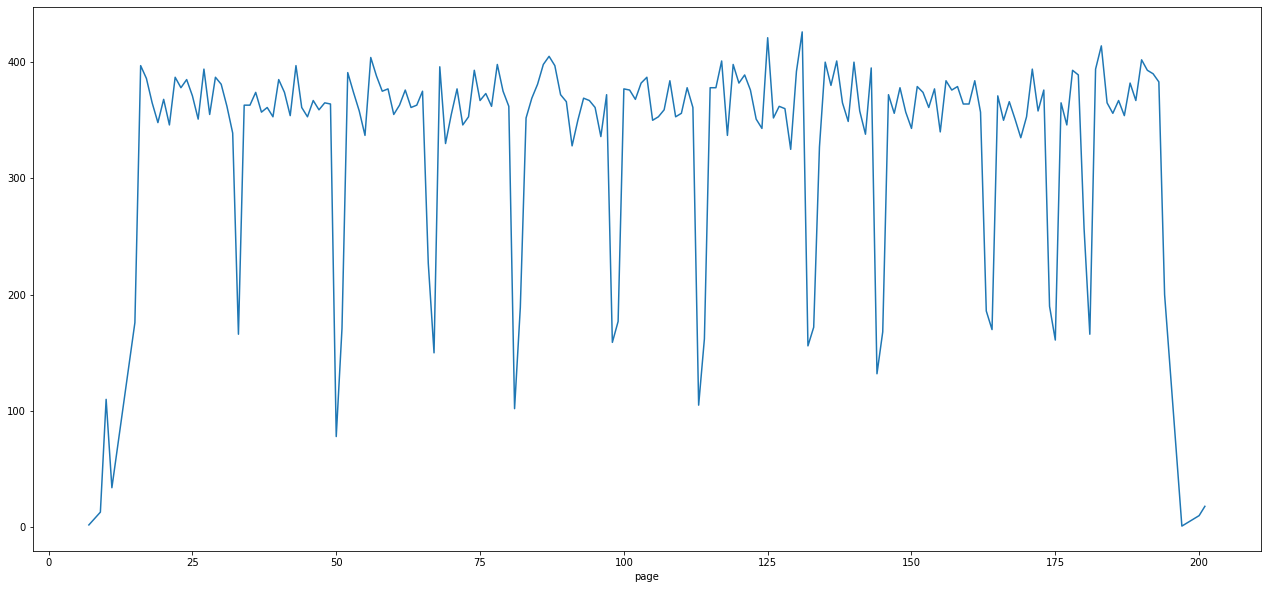

In [11]:
tkns_df = test_vol.tokens_per_page()
tkns_df.plot(figsize=(22,10))

# if you want to compare to another volume, here is code for looking at Mrs. Dalloway by Virginia Woolf:
# md_vol = Volume('mdp.39015002299421')
# md_tkns = md_vol.tokens_per_page()
# md_tkns.plot(figsize=(22,10))

Anything interesting here?

Similarly, we can use the FeatureReader for more complex exploratory analysis. Maybe we suspect that parts of our volume contained poetry, we may wish to see if there are any perceivable increases or decrease of capitalized begin line characters in our volume. We could check this with the FeatureReader and a handful of lines of code:

blc_df has 27456 rows and 1 columns


/usr/local/lib/python3.7/dist-packages/htrc_features/parsers.py:428: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  df.sort_index(0, inplace=True)


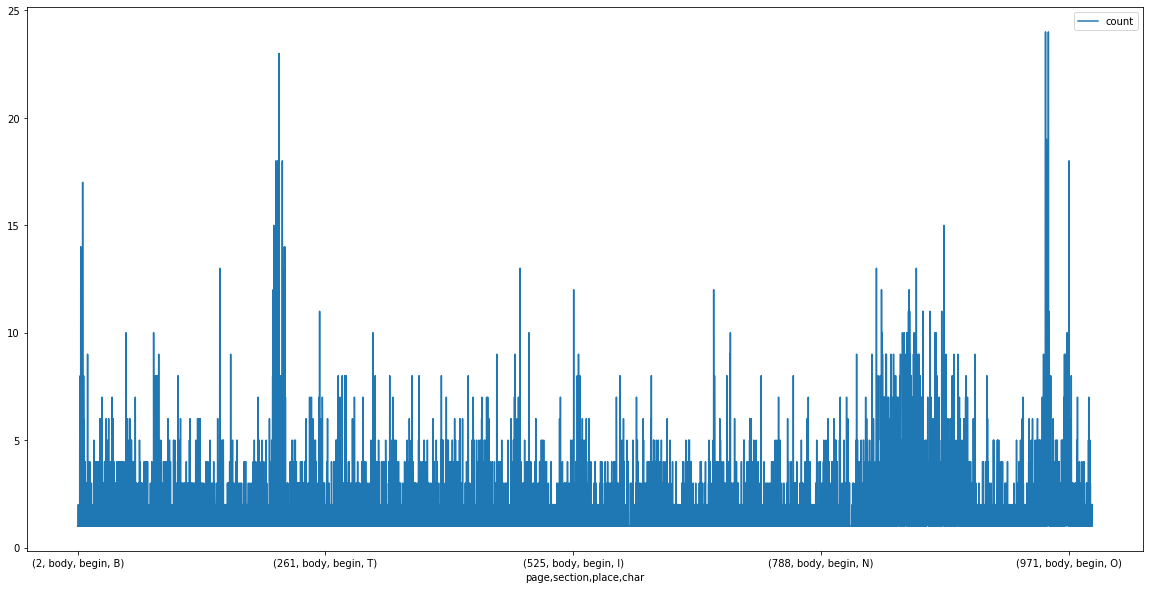

In [12]:
# Create a new Volume from one anthology of Harper's Weekly, a publication known to publish both prose and poetry:
blc_test_vol = Volume('coo.31924054824473')

# create a DF with begin line characters only:
blc_df = blc_test_vol.begin_line_chars()
# blc_df.head(10)

# print the shape of our blc DF
print(f"blc_df has {blc_df.shape[0]} rows and {blc_df.shape[1]} columns")

# make a new DF with only capitalized alphabetic begin line characters, by page:
caps_blc_df = blc_df.loc[(slice(None), slice(None), slice(None), ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'],)]

# plot the above df!
caps_blc_df.plot(figsize=(20,10))

This plot is showing us the counts of capitalized begin line characters per page, and shows spikes around page 240-300, and then later in the volume. This shows where we are likely to have poetry in this volume, and happens to line up with more rigorous poetry-identifying work we've done in [another EF use case](https://wiki.htrc.illinois.edu/x/IQKGAQ).

## Topic Modeling with Token Lists

At this point, you're probably wondering when we'll get to topic modeling using the tokens (words) themselves. Let's not delay any longer and dive in. 

Before we topic model, let's look a bit at how we can see and interact with tokens. The most flexible way to do this is to create a token list DataFrame (DF) using the method `vol.token_list()`. This method can be given extra options to get different versions of the data back, and these are called "parameters." Let's take a look at the possible parameters first (maybe learning a handy trick), and then explore a token list. To see the possible parameters for a given function or method, you can type its name as if you were going to run it, but with a `?` instead of parentheses `()`:

In [13]:
# test_vol.tokenlist?

tv_pf = test_vol.page_features()
tv_pf.head(25) 

,version,calculatedLanguage
page,,
1,68b329da9893e34099c7d8ad5cb9c940,None
2,e1c06d85ae7b8b032bef47e42e4c08f9,None
3,d41d8cd98f00b204e9800998ecf8427e,None
4,d41d8cd98f00b204e9800998ecf8427e,None
5,d41d8cd98f00b204e9800998ecf8427e,None
6,d41d8cd98f00b204e9800998ecf8427e,None
7,d78bd3bf58d8e286c1191d2cdea41019,en
8,d41d8cd98f00b204e9800998ecf8427e,None
9,64fd0508c434a2a4906d816a2f05cb80,en


The above code will not only show us the parameters, but will return the entire Docstring help text for the function, which should not only tell you possible parameters, but also their default values, the data types the function and each parameter takes, the output of the function and even examples of how to use it and what it will return. One thing to keep in mind, though, is that this info is submitted by the author of the library, so how thorough or helpful this help text is can vary wildly between libraries!

Ok, with a new trick under our belts, let's create our first token list to see what info is available. While we do this, we'll also assign the output of `.tokenlist()` to a variable and use `.head()` to look at the first 5 rows of data, since we know the output of `.tokenlist()` is a DataFrame:

In [14]:
test_df = test_vol.tokenlist()
test_df.head()

count
page section token     pos       
7    body    Outsiders NNS      1
             The       DT       1
9    body    E.        NNP      1
             Flic      NNP      1
             Hinton    NNP      1

Since we looked at an EF file, this data should look familiar, but the structure has been flattened a bit to fit into a DataFrame, which can make it easier to read to our human (hopefully!) eyes. Another interesting thing to note is that the DataFrame returned by `.tokenlist()` has a multi-index. This means that more columns than just a hidden numerical index are treated like an index--that is, you can easily search those levels of data for certain values.This is why we could use `.loc` to quickly find certain letters in our capitalized begin line character example above. This is a powerful way to find certain tokens or parts-of-speech or to do so on specific pages or sections of a volume, though we won't demo that here.

Instead, let's turn directly to using Extracted Features files to topic model our data. Right now, we can get the tokens for each page in a given HathiTrust volume in a highly structured format, a token list. Most topic modeling tools simply want the tokens for each volume/document/page in bag-of-words format. You can think of the bag-of-words format exactly as it sounds:

![](https://drive.google.com/uc?export=view&id=1LHus0vtaiKxKIBIyimtSJOjvqaH4O6Oi)

We take each word from a passage of text, drop it in a "bag" where it loses its original order but still represents the explicit pieces of the original text. Topic modeling is based on co-occurrence between words and word occurrence at the document and topic level, which is why the original semantic structure of the text is irrelevant.

In order to convert EF files to bag-of-words text, we need to write a bit of custom code. We'll define a new function that will parse EF files, grab the tokens for each page and volume and add them to a large DataFrame that will have bag-of-words tokens as one of its columns, along with HTID and page number and a few others. We call this function `ef_vol_to_bow_df` and it takes a FeatureReader `Volume` as an input as well as an optional parameter to save the DataFrame to a TSV. Since this function takes one volume as an input, we'll need to wrap it in some iteration code in order to reformat multiple volumes. Here is the function:

In [16]:
def ef_vol_to_bow_df(volume, save_to_tsv=False):
    from htrc_features import FeatureReader, Volume
    import pandas as pd
    from tqdm.notebook import trange, tqdm
    import os
    notebook_path = os.getcwd()
    htid = volume.id
    # creating an empty Dataframe to which we'll add clean tokens, instead of a text file
    vol_df = pd.DataFrame(columns=['htid', 'page_number', 'page_tokens'])
    outfile_name = htid+'.tsv' # saving our volume-level token DataFrame to a TSV
    for page in tqdm(volume.pages(), total=volume.page_count):
        page_num = str(page).split(' ')[1]
        page_df = page.tokenlist(section='body', case=False, pos=False)
        tkn_list = []
        
        for i, r in page_df.iterrows():
            tkn = i[2]
            clean_tkn = tkn.strip()
            count = r[0]
            tkns = ([f'{clean_tkn}'] * count)
            clean_tkn_list = [word for word in tkns if word.isalpha()]
            clean_tkn_list = [word for word in clean_tkn_list if word not in en_stop]
            tkn_list.extend(clean_tkn_list)
        '''
        Instead of writing to text files, we are adding the page-level clean tokens to our
        DataFrame, with one each page of tokens constituting one row in the DataFrame.
        '''
        vol_df = vol_df.append({'htid': htid, 'page_number':  page_num, 'page_tokens':tkn_list}, ignore_index=True)
    '''
    Lastly, we save our volume-level DataFrame as a tab-separated file, and return the volume 
    DataFrame so that we can better aggregate each volume's tokens into a single DataFrame (you'll 
    see this code in the wrapper we write to iterate through multiple volumes)
    '''
    if save_to_tsv==True:
        vol_df.to_csv(outfile_name, sep='\t', index=False)
        print(f'Saved {volume.title} to TSV named {outfile_name}')
    
    print(f'Reformatted "{volume.title}" ({htid}) to bag-of-words')
    return vol_df

Before we run this function to test it out, we will download a standard set of stop words--the words we want to remove from the text before analysis--and decide if we want to add any additional words to this list. For this workshop, we've built removing stop words into the function that readies EF files for topic modeling. We'll use the standard English stop words from the Natural Language Toolkit (`nltk`) to start with. We have cheated (by running this already) to find that we should make some additions, which we'll do using `.add()` the syntax for adding items to a `Set` (a `Set` is basically a list, but where every item in it is unique and with some extra properties):

In [17]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

en_stop.add("'")
en_stop.add('"')
en_stop.add(' ')
en_stop.add('would')
en_stop.add('could')
en_stop.add('should')
en_stop.add('said')
en_stop.add('also')

# If we wanted to be a bit more clever, we could use a simple loop to add these words to our stop list with less typing:

# stop_words_to_add = ["'",'"',' ','would','could','should','also', 'said']

# for word in stop_words_to_add:
#     en_stop.add(word)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


With a list of stop words defined, we can write a few lines of code to iteratively deploy it and test the results. We'll first use three HTIDs for test volumes (the first three books of George RR Martin's *A Song of Ice and Fire* series) and then create a `for` loop to run our `ef_vol_to_bow_pages` function over all three volumes:

In [19]:
# YOU COULD SUBSTITUTE ANY VOLUMES YOU'D LIKE HERE, JUST REPLACE THE BELOW HTIDs!
volume_list = ['mdp.39015066088678','mdp.39015020645456','mdp.39015063676970']

workset_page_df = pd.DataFrame(columns=['htid','page_number','page_tokens'])

for book in tqdm(volume_list):
    fr_vol = Volume(book)
    book_df = ef_vol_to_bow_df(fr_vol, save_to_tsv=True)
    workset_page_df = workset_page_df.append(book_df)
    
print(f"Reformatted {len(volume_list)} volumes to bag-of-words pages.")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Saved The outsiders / to TSV named mdp.39015066088678.tsv
Reformatted "The outsiders /" (mdp.39015066088678) to bag-of-words


  0%|          | 0/200 [00:00<?, ?it/s]

Saved Fahrenheit 451. to TSV named mdp.39015020645456.tsv
Reformatted "Fahrenheit 451." (mdp.39015020645456) to bag-of-words


  0%|          | 0/344 [00:00<?, ?it/s]

Saved Star wars : dark lord : the rise of Darth Vader / to TSV named mdp.39015063676970.tsv
Reformatted "Star wars : dark lord : the rise of Darth Vader /" (mdp.39015063676970) to bag-of-words
Reformatted 3 volumes to bag-of-words pages.


Things look to have run successfully (hopefully!). Let's check the dimensions (rows, columns) and look at the output DataFrame to verify:

In [20]:
print(workset_page_df.shape)
workset_page_df.head(10)

(746, 3)


,htid,page_number,page_tokens
0,mdp.39015066088678,1,[]
1,mdp.39015066088678,2,[]
2,mdp.39015066088678,3,[]
3,mdp.39015066088678,4,[]
4,mdp.39015066088678,5,[]
5,mdp.39015066088678,6,[]
6,mdp.39015066088678,7,[outsiders]
7,mdp.39015066088678,8,[]
8,mdp.39015066088678,9,"[flic, hinton, new, oiitsiilci, press, viking,..."
9,mdp.39015066088678,10,"[avenue, book, canada, canada, card, catalog, ..."


The dimensions look right, as does the data in `workset_page_df`. 

We can now shift to grabbing the bag-of-words text in the `page_tokens` column and readying it for Gensim. We're using a straightforward, no frills version of topic modeling where we aren't tracking the documents in our collection, and are instead just topic modeling the words. For this, Gensim wants one big list of the tokens, and we'll generate this using another `for` loop:

In [21]:
bow_text_lists = []
bow_text = []

for i,r in workset_page_df.iterrows():
    words = r.page_tokens
    bow_text_lists.append(words)
    for word in words:
        bow_text.append(word)

print(f"Added {len(bow_text)} words to list.")

Added 91019 words to list.


Gensim takes "dictionary" and "corpus" objects to train an LDA model. For Gensim, a "dictionary" is a list of the unique tokens in your corpus, assigned to a numerical ID, and a "corpus" is your complete bag-of-words data--the list of words we just created, `bow_text`--but represented by the numerical ID from the "dictionary" and its count. This is a bit confusing, so let's generate both and take a look at them directly. Here is the code to create the dictionary and corpus, pulled from Gensim documentation:

In [30]:
# importing libraries from Gensim to create corpus and dictionary
from gensim import corpora

# creating our dictionary and corpus
dictionary = corpora.Dictionary(bow_text_lists)
corpus = [dictionary.doc2bow(text) for text in bow_text_lists]

# importing pickle, a library which lets us save our corpus and dictionary for later use
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

Here is a look at the first 15 items in our Gensim `dictionary`:

In [31]:
n = 0

for k,v in dictionary.items():
    if n <= 15:
        print(f"{k} : {v}")
        n += 1

0 : outsiders
1 : flic
2 : hinton
3 : new
4 : oiitsiilci
5 : press
6 : viking
7 : york
8 : avenue
9 : book
10 : canada
11 : card
12 : catalog
13 : company
14 : complete
15 : congress


And here is one page of bag-of-words data (represented numerically as `(word ID, count)` pairs or tuples) in our Gensim `corpus`:

In [33]:
# return item 5 in our corpus:
corpus[5]

[]

With these two inputs created, we can now train and run our topic model, saving the model along the way (again, pulling code from Gensim documentation--you don't have to know how to do this off the top of your head!):

In [34]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# THIS CODE WILL TAKE A FEW MINUTES OR SO TO RUN!
number_of_topics = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = number_of_topics, id2word=dictionary, passes=50, random_state=42)
ldamodel.save('model10.gensim')

Three major inputs are adjustable: the number of topics we want to generate, the number of passes we want to do when training our model, and the random state or seed. The number of topics is custom for each set of volumes/documents and is often something that you should test out. Do your results make more or less sense with more or fewer topics? The number of passes will effect the "accuracy" of your topic models. The algorithm is training the topics as many times as you input passes, and then taking an aggregated average of the results. Since there is a random element to topic modeling, results are different for every pass. The more passes we do, the more we can reduce the randomness of the results. Here, we're doing 50 passes, since our data is not too big, but you may find more or less is suitable based on testing out results. Another way to minimize the randomness is to set the seed, or in Gensim the `random_state`. By setting the "seed" or the `random_state` we are saying to eliminate the randomness and always go with the number option we indicate. You can play with this number as well and see how the results change. We have started with 42 because it is the answer to eveything.

Ok, back to results!

Nothing is explicitly returned from the code above, as the model is created and saved, but we can see the topics that were generated using `show_topics()` which also lets us decide how many of the top words for each topic we want to see:

In [35]:
topics = ldamodel.show_topics(num_words=10, formatted=False)
for topic in topics:
    print(f"{topic} + '\n'")

# doc_topics = ldamodel.get_doc_topics

(0, [('vader', 0.027254019), ('jedi', 0.016719393), ('shryne', 0.01205169), ('palpatine', 0.0076688468), ('sidious', 0.006794068), ('one', 0.006369199), ('bail', 0.0061004823), ('lord', 0.005753233), ('force', 0.0055495207), ('starstone', 0.0047366098)]) + '
'
(1, [('cudgel', 0.011247659), ('starstone', 0.007669002), ('filli', 0.0061941296), ('chewbacca', 0.004973599), ('wookiees', 0.0043572607), ('droids', 0.0034725121), ('kashyyyk', 0.0028394267), ('tarfful', 0.002606386), ('kachirho', 0.0024250033), ('side', 0.0023420379)]) + '
'
(2, [('montag', 0.020408941), ('like', 0.009457672), ('one', 0.007387464), ('back', 0.006928328), ('man', 0.0066679106), ('beatty', 0.005611611), ('know', 0.0051163435), ('night', 0.0050687226), ('books', 0.0048089866), ('go', 0.0047772755)]) + '
'
(3, [('montag', 0.0052689123), ('thought', 0.0040017916), ('running', 0.0038168745), ('face', 0.0037564947), ('like', 0.003472511), ('hand', 0.0033924873), ('hands', 0.0031232224), ('house', 0.0030469284), ('houn


We can also get all the documents for which a term has an association in our model using Gensim's `get_term_topics` method, which takes a term and a minimum probability and returns each topic for which that term meets the minimum probability of appearing in. We can see all topics for a given term simply by passing `0` to the parameter `minimum_probability`:



In [36]:
ldamodel.get_term_topics('brave', minimum_probability=0)


[(2, 4.1984706e-05), (9, 0.00027346626)]

While it's very useful to see our topics, the top N terms associated with them, and be able to check topic association for a given term, we may also want to see how each of our documents associates with our topics. We can use Gensim's `get_document_topics` method for this (and remember that a 'document' for us is a page of a HathiTrust volume):

In [37]:
all_topics = ldamodel.get_document_topics(corpus, per_word_topics=True)
n = 0

for doc_topics, word_topics, phi_values in all_topics[20:25]:
    print(f"Document {n}\n")
    print('Document topics (what topics this document is associated with):')
    print(f"{doc_topics}\n")
    print('Word topics (what topics words in this document are associated with):')
    print(f"{word_topics}\n")
    print('Phi values (probability of a word in this document being associated with a given topic):')
    print(f"{phi_values}\n")
    print('-------------- \n')
    n += 1

Document 0

Document topics (what topics this document is associated with):
[(2, 0.27562374), (8, 0.7174788)]

Word topics (what topics words in this document are associated with):
[(48, [8, 2]), (49, [8, 2]), (59, [8, 2]), (63, [8]), (68, [8]), (72, [8, 2]), (76, [8, 2]), (77, [8, 2]), (78, [8, 2]), (93, [8]), (97, [8, 2]), (107, [8, 2]), (118, [8]), (132, [8]), (139, [8, 2]), (147, [8, 2]), (148, [8, 2]), (172, [8, 2]), (176, [8]), (177, [8]), (190, [8, 2]), (192, [8, 2]), (234, [8, 2]), (235, [8, 2]), (255, [8, 2]), (260, [8, 2]), (289, [8]), (301, [8, 2]), (306, [8, 2]), (318, [8, 2]), (325, [8, 2]), (333, [8, 2]), (336, [8, 2]), (345, [8]), (362, [8, 2]), (367, [8, 2]), (369, [8, 2]), (401, [8, 2]), (407, [8, 2]), (412, [8, 2]), (416, [8]), (428, [8, 2]), (454, [8]), (457, [8, 2]), (466, [8]), (472, [8]), (479, [8, 2]), (484, [8, 2]), (492, [2]), (493, [2]), (494, [2]), (495, [2]), (496, [8, 2]), (497, [8]), (498, [8, 2]), (499, [8, 2]), (500, [2]), (501, [8, 2]), (502, [8, 2]), (

We can also Write out the topics and their top n words (here, n=25) to a file with the following code (**Note: this doesn't work in Google Colab**):

In [38]:
# DOESN'T WORK FOR COLAB, SADLY!
topics = ldamodel.show_topics(num_topics=5, num_words=25)

with open('asoiaf_topics_5.tsv', 'a') as f:
    for topic in topics:
        topic_num = topic[0]
        topic_words = topic[1]
        f.write(f"{topic_num} + '\t' + {topic_words} + '\n'")

Now, with our topic modeling results, the fun begins--interpreting what we see. For this set of books, *A Game of Thrones*, *A Clash of Kings* and *A Storm of Swords*, the results *seem* to make sense, as we see the clustering of characters that interact with each other heavily, as well as thematic elements for those characters and their narrative arcs.

We can use another library called `pyLDAvis` to better visualize our topics, and see if they still make sense:

In [39]:
# load the dictionary, corpus, and LDA model we created earlier:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))

# If you generate a new model and change the number of topics, you may need to change the file name for the model (here, model5.gensim)
lda = gensim.models.ldamodel.LdaModel.load('model10.gensim')

# import pyLDAvis and ready it for use in a notebook:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed pyLDAvis the pieces generated from Gensim and create the visualization:
lda_display = gensimvis.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


That's it! You've topic modeled 3 books, tens of thousands of words, using Gensim and HTRC Extracted Features. However, since topic modeling has a random seed, you should continue to explore by tweaking the inputs: stop words, number of topics, passes, and the random seed itself. We could also topic model while retaining the structure of the original pages/documents, or chunking our text into smaller pieces and reviewing how the results might change. Since topic modeling is really great for exploring data, we shouldn't be shy when it comes to experimenting with inputs and data. You'll never know how good results can be until you try different methods of generating them.

**Questions about this notebook?** Contact HTRC at htrc-help@hathitrust.org

CC-BY-NC 4.0 (2021)